In [3]:
import numpy as np
import numpy.linalg as linalg
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import preprocessing

sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('data/real-estate.csv')
data.columns = ['No', 'date', 'age','distance_to_MRT','stores', 'latitude', 'longitude','price']
data = data[['age','distance_to_MRT','stores', 'latitude', 'longitude','price']]
data = data.drop(index=data['price'].idxmax()).reset_index()
data = data.drop(columns=['index'])

In [3]:
data.describe()

,age,distance_to_MRT,stores,latitude,longitude,price
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,17.729298,1085.898530,4.101695,24.969017,121.533368,37.787651
std,11.401205,1262.974876,2.945182,0.012422,0.015365,13.046097
min,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,9.000000,289.324800,1.000000,24.962990,121.527600,27.700000
50%,16.100000,492.231300,4.000000,24.971100,121.538630,38.400000
75%,28.200000,1455.798000,6.000000,24.977460,121.543310,46.600000
max,43.800000,6488.021000,10.000000,25.014590,121.566270,78.300000


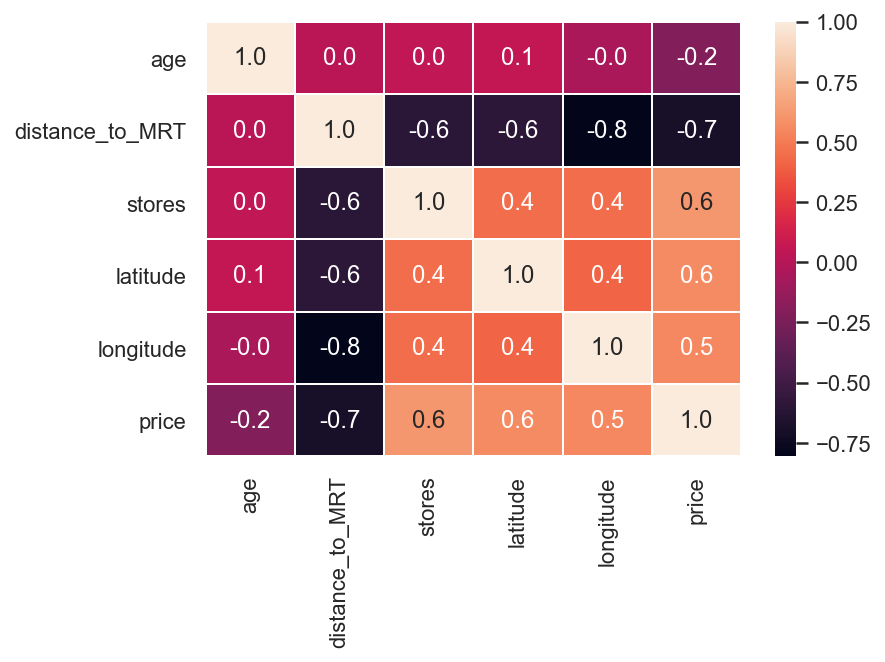

In [7]:
sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidths=.5);

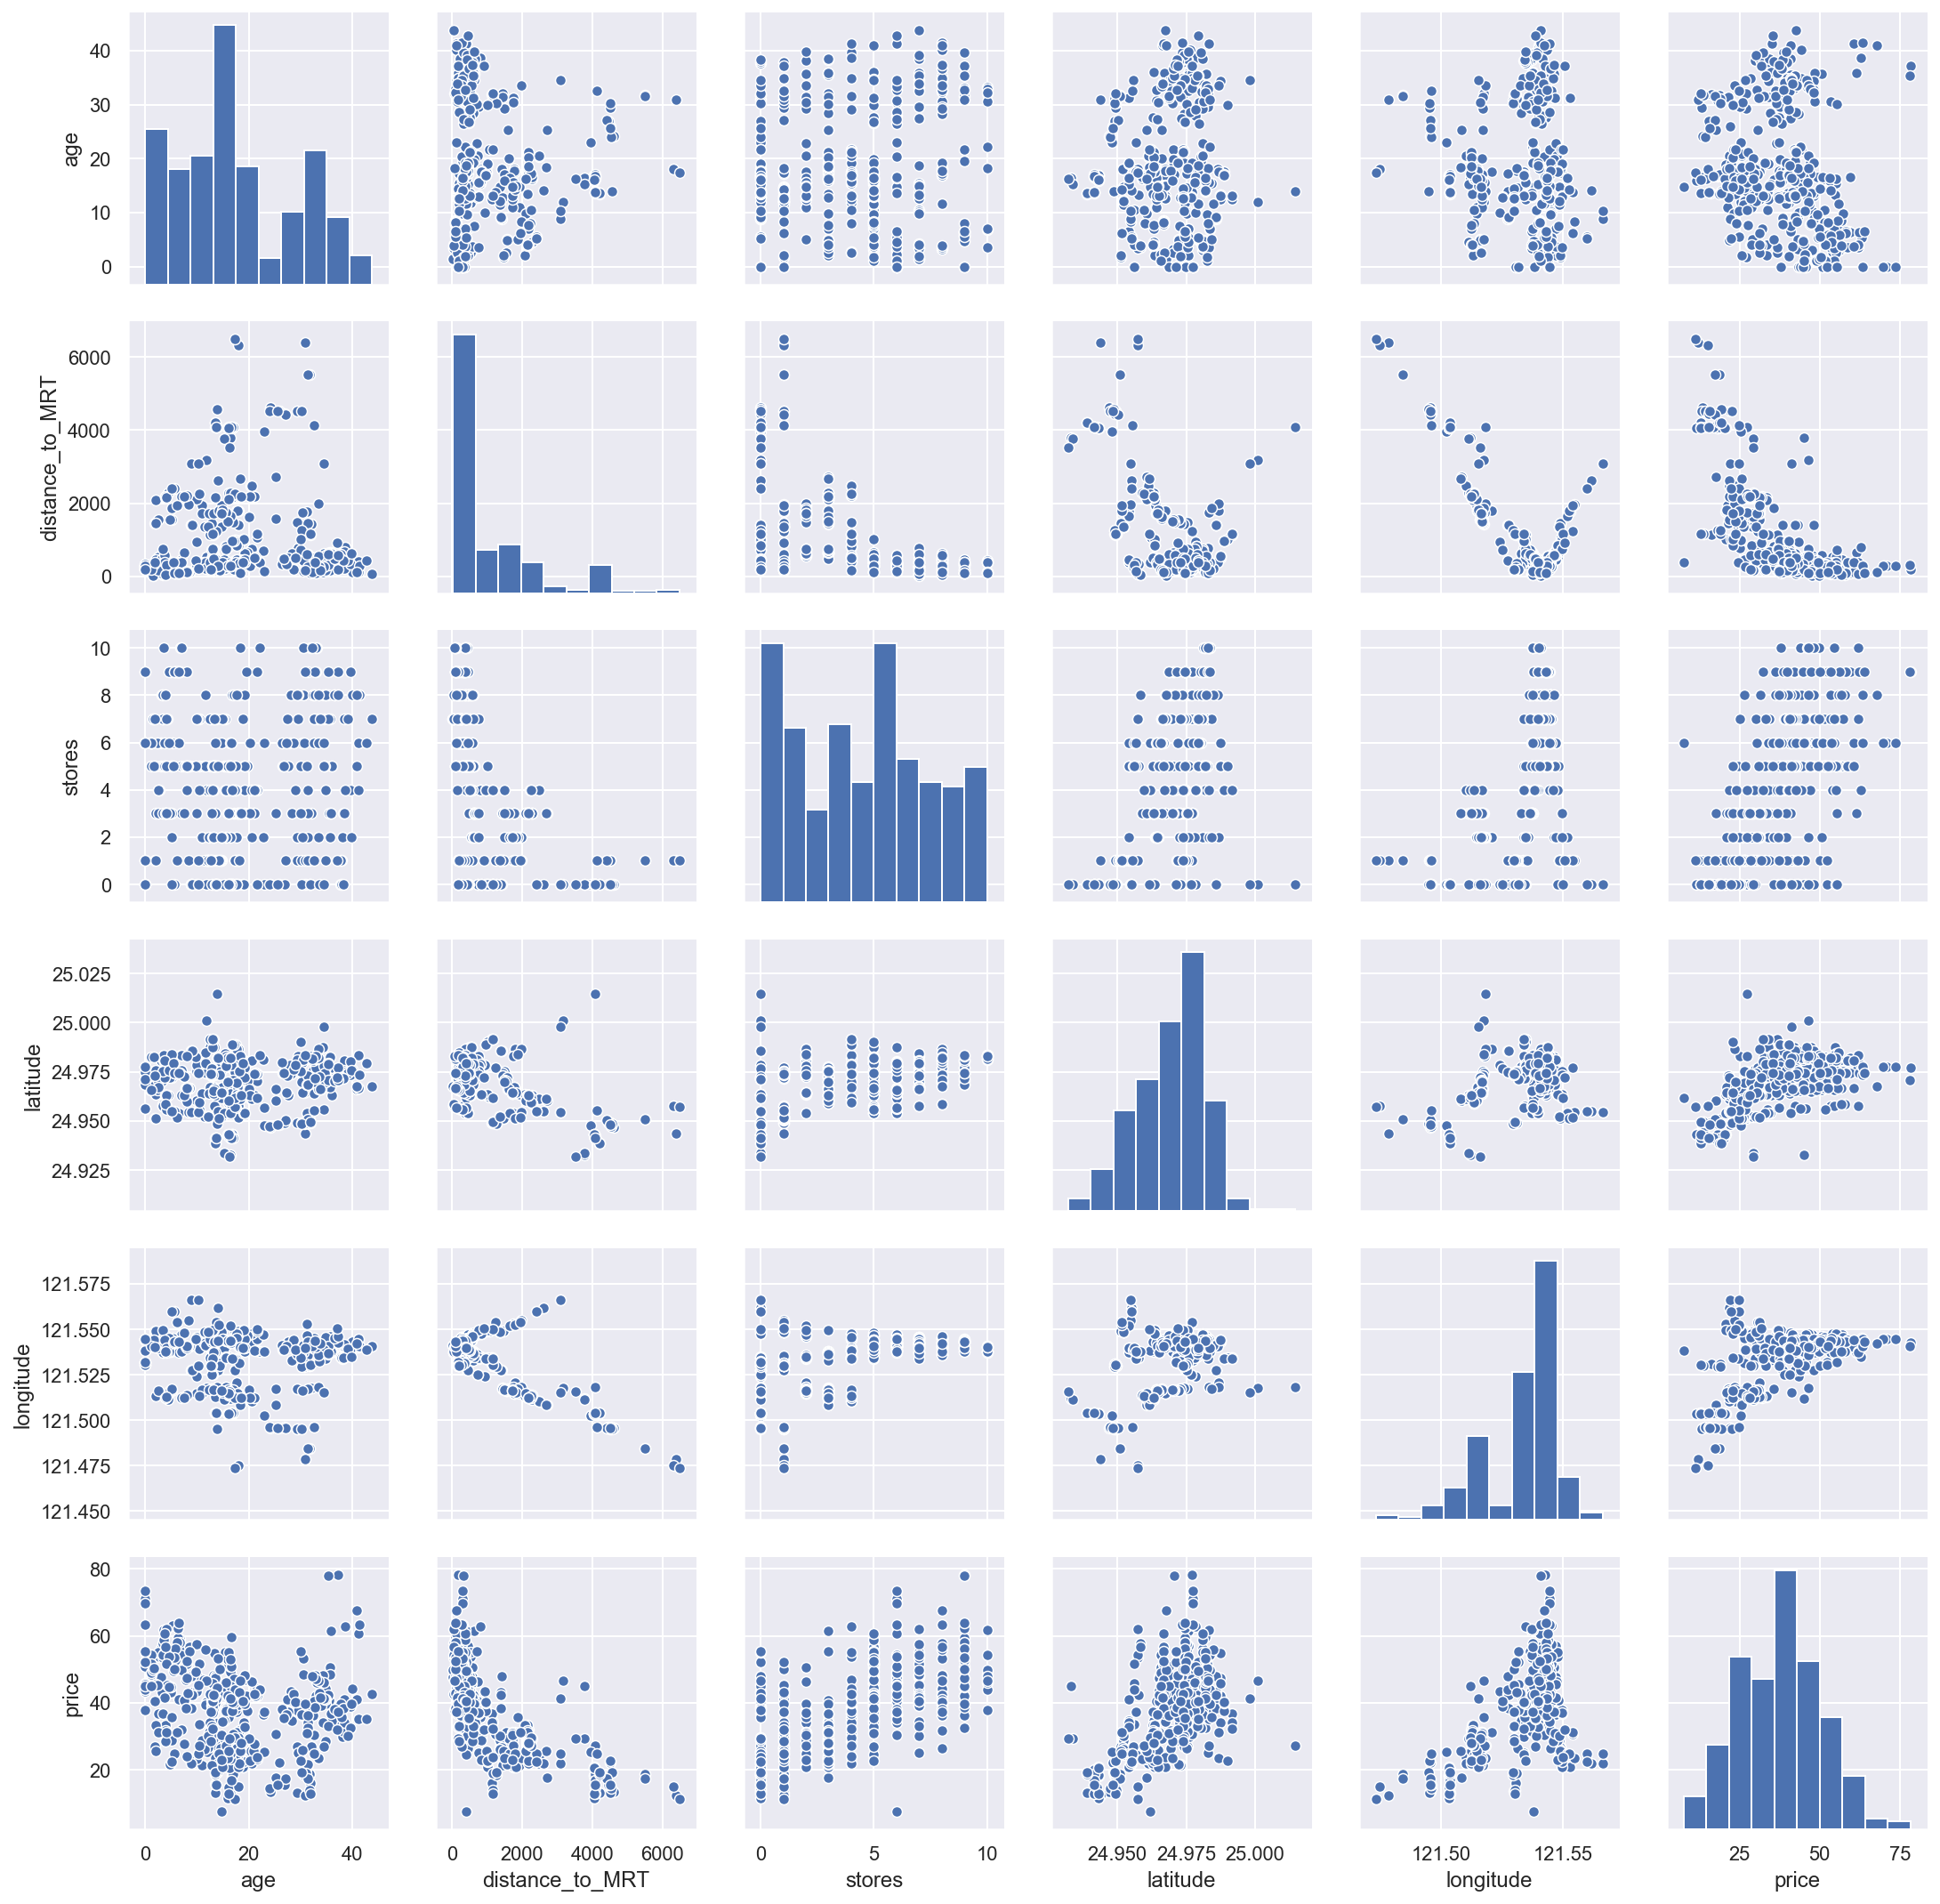

In [44]:
sns.pairplot(data);

In [11]:
def get_H(data, features_lst):
    feature_arr = np.empty((data.shape[0], len(features_lst) + 1))
    feature_arr[:, 0] = 1
    feature_arr[:, 1:] = data[features_lst]
    return feature_arr

def get_poly(data, poly_degree):
    poly = np.zeros((data.size, poly_degree + 1))
    for col_num in range(poly_degree + 1):
        poly[:, col_num] = data**col_num
    return poly

def getRSS(H, y, pred_koeff):
    return (y - H.dot(pred_koeff)).T.dot(y - H.dot(pred_koeff))

def get_pred_koeff(H, y):
    return linalg.inv(H.T.dot(H)).dot(H.T).dot(y)

In [26]:
def get_avg_MSE(H, y):
    kf = KFold(n_splits=5)
    MSE_sum = 0
    for train, test in kf.split(y):
        pred_koeff = get_pred_koeff(H[train, :], y[train])
        MSE_sum += getRSS(H[test, :], y[test], pred_koeff) / y[test].shape[0]
    return MSE_sum / 5

In [27]:
H = get_H(data, ['age','distance_to_MRT','stores', 'latitude', 'longitude'])
y = np.array(data['price'])
get_avg_MSE(H, y)

66.21546823492106

In [30]:
def best_degree(x, y, max_poly_degree, ax, name):
    kf = KFold(n_splits=5)
    avg_MSE = []
    for poly_degree in range(1, max_poly_degree + 1, 1):
        MSE_sum = 0
        for train, test in kf.split(x):
            H_train = get_poly(x[train], poly_degree)
            pred_koeff = get_pred_koeff(H_train, y[train])
            H_test = get_poly(x[test], poly_degree)
            MSE_sum += getRSS(H_test, y[test], pred_koeff) / y[test].shape[0] 
        avg_MSE.append(MSE_sum / 5)
    min_avg_MSE_idx = np.argmin(avg_MSE)
    ax.set_title(
        name +
        ' (best degree - ' + str(min_avg_MSE_idx + 1) + 
        ', MSE - ' + str(round(avg_MSE[min_avg_MSE_idx], 2)) + ')')
    ax.plot(range(1, len(avg_MSE) + 1, 1), avg_MSE);

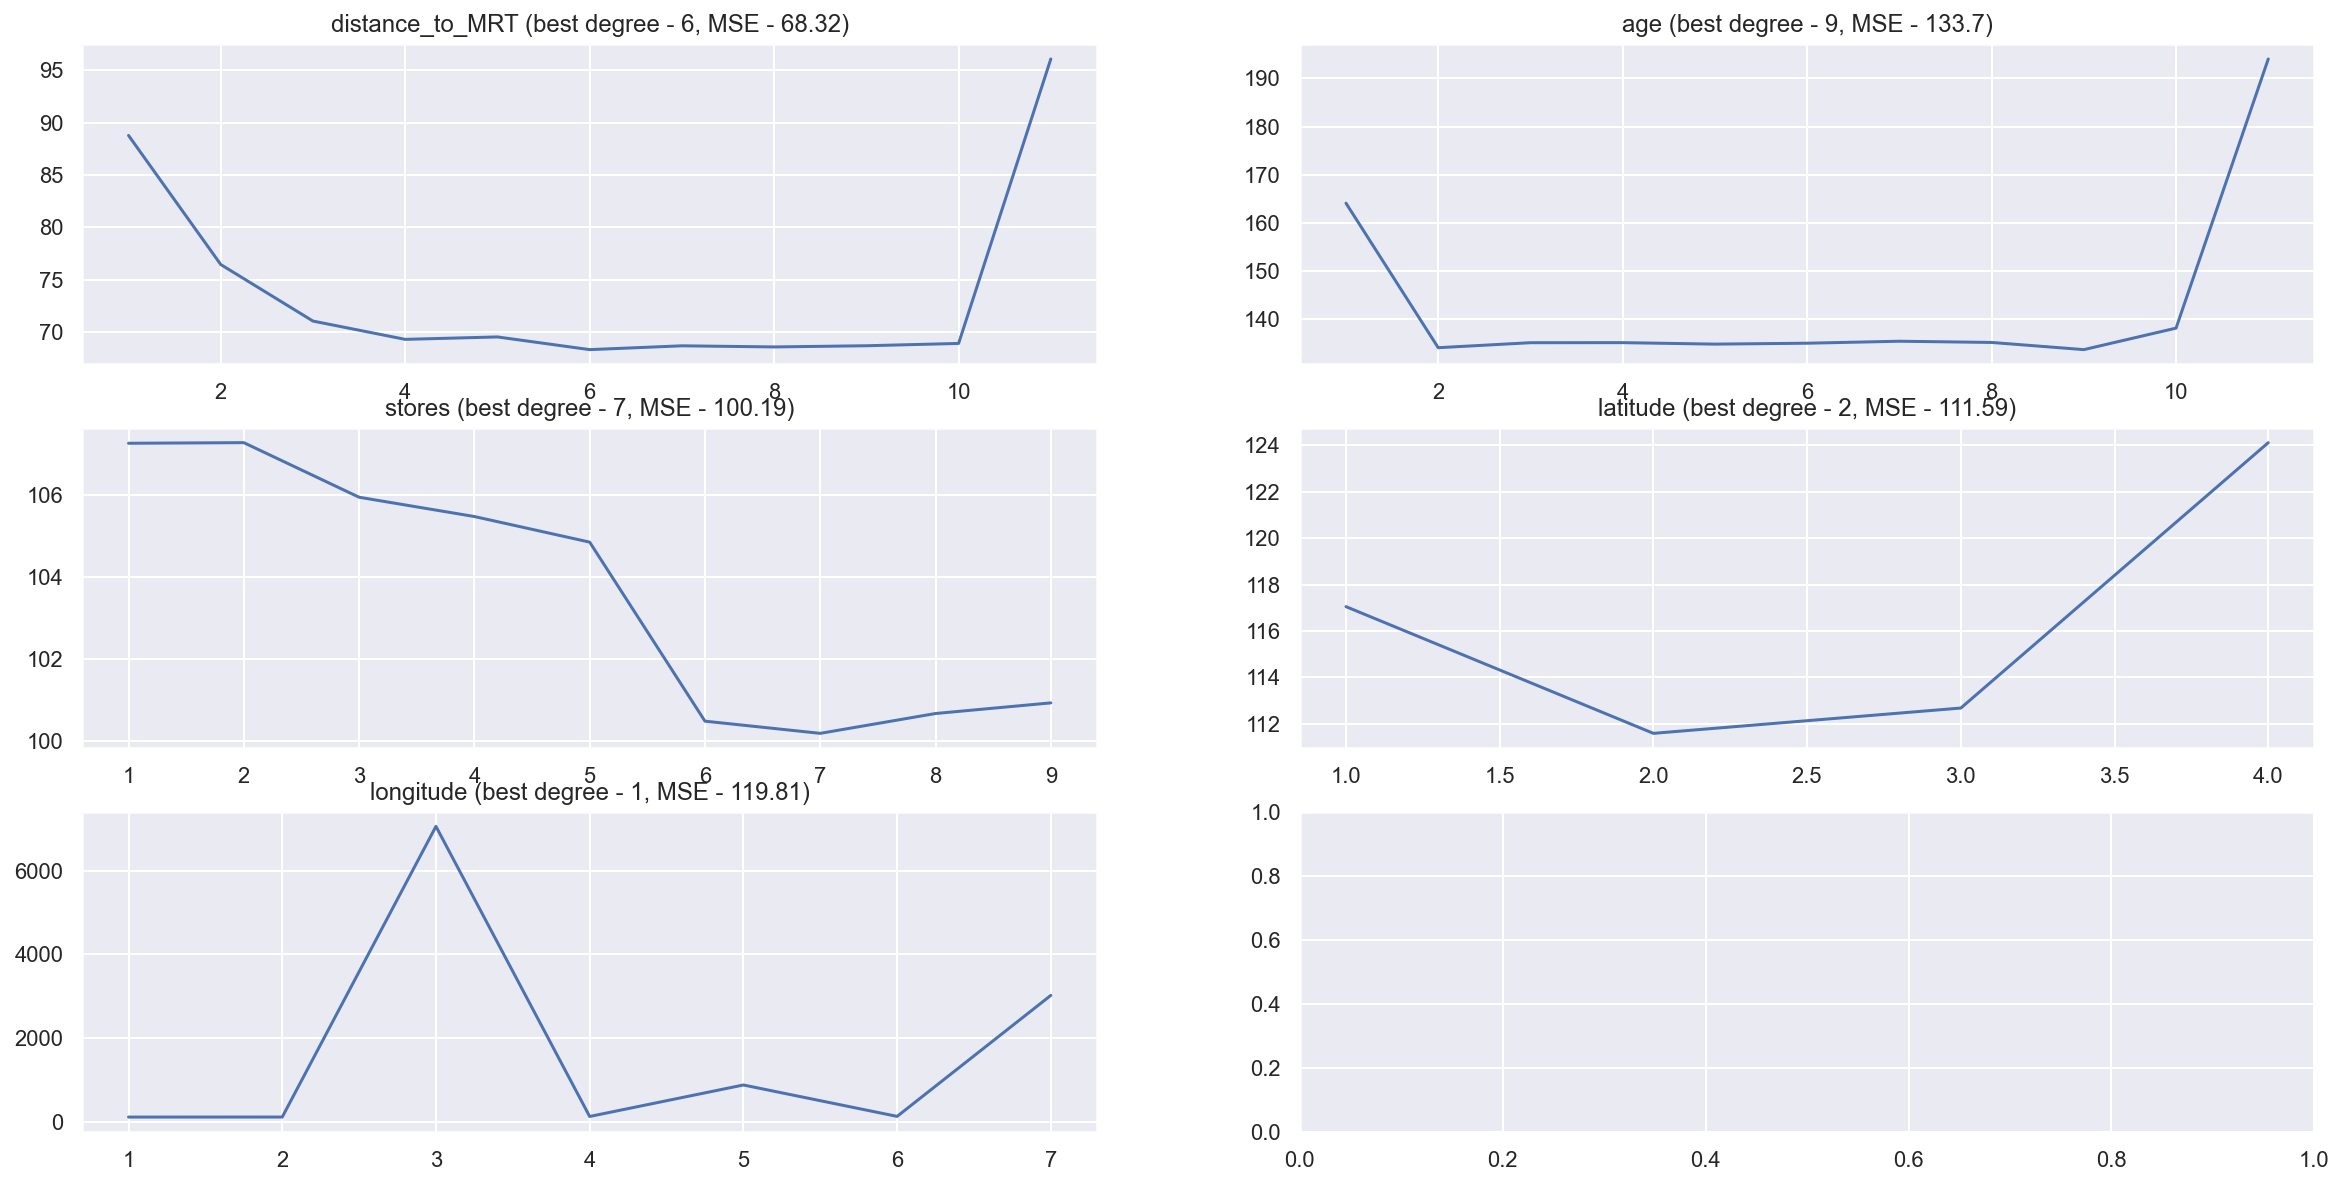

In [31]:
y = np.array(data['price'])
figure, axes = plt.subplots(3, 2, figsize=(20,10))
best_degree(data['distance_to_MRT'], y, 11, axes[(0,0)], 'distance_to_MRT')
best_degree(data['age'], y, 11, axes[(0,1)], 'age')
best_degree(data['stores'], y, 9, axes[(1,0)], 'stores')
best_degree(data['latitude'], y, 4, axes[(1,1)], 'latitude')
best_degree(data['longitude'], y, 7, axes[(2,0)], 'longitude')

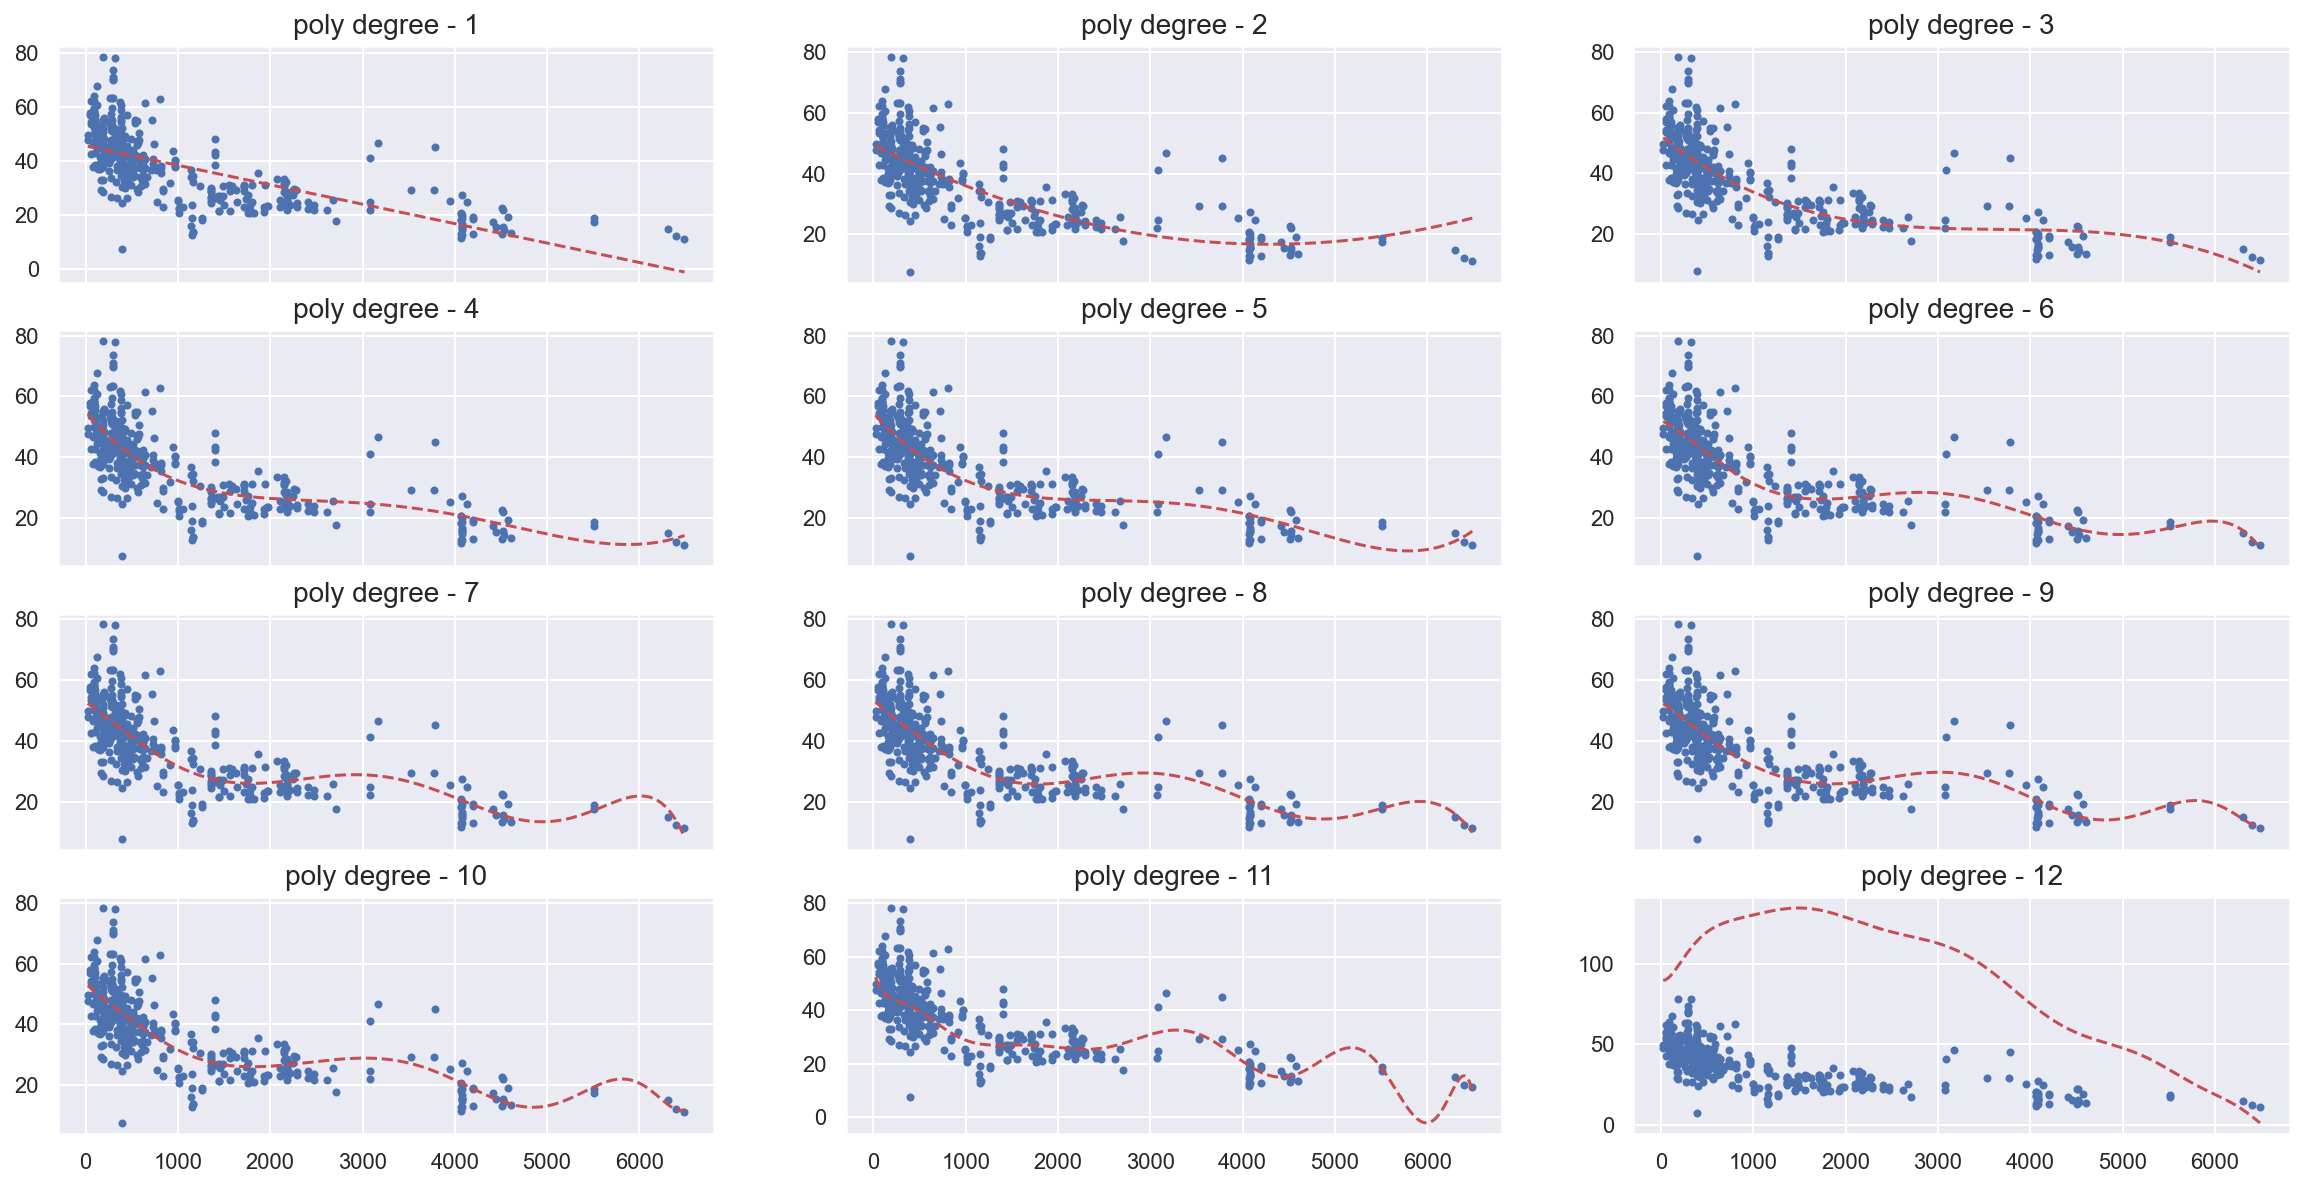

In [19]:
x = np.array(data['distance_to_MRT'])
y = np.array(data['price'])
max_poly_degree = 12
plot_col_num = 3
plot_rows_num = int(math.ceil(max_poly_degree / plot_col_num))
figure, axes = plt.subplots(plot_rows_num, plot_col_num, sharex=True, sharey=False, figsize=(20,10))
x_line = np.linspace(math.floor(min(x)), math.ceil(max(x)), 1000)
np.set_printoptions(precision=2, suppress=True)
for poly_degree in range(1, max_poly_degree + 1, 1):
    H = get_poly(x, poly_degree)
    pred_koeff = linalg.inv(H.T.dot(H)).dot(H.T).dot(y)
#     print(str(poly_degree) + '. ' + str(getRSS(H, y, pred_koeff)))
    plot_pos = (int((poly_degree - 1) / plot_col_num), (poly_degree - 1) % plot_col_num)
    axes[plot_pos].set_title('poly degree - ' + str(poly_degree), fontsize=14)
    axes[plot_pos].plot(x_line, get_poly(x_line, poly_degree).dot(pred_koeff), 'r--')
    axes[plot_pos].scatter(x, y, marker='.')

In [45]:
H = np.concatenate((
    get_poly(data['distance_to_MRT'], 2), 
    get_poly(data['age'], 6)[:, 1:],
    get_poly(data['stores'], 7)[:, 1:],
    get_poly(data['latitude'], 2)[:, 1:],
    get_poly(data['longitude'], 1)[:, 1:]), axis=1)
y = np.array(data['price'])
get_avg_MSE(H, y)

Wall time: 5.99 ms


55.70855738953634

In [47]:
%%time
H = np.concatenate((
    get_poly(data['distance_to_MRT'], 15), 
    get_poly(data['age'], 15)[:, 1:],
    get_poly(data['stores'], 15)[:, 1:],
    get_poly(data['latitude'], 15)[:, 1:],
    get_poly(data['longitude'], 15)[:, 1:]), axis=1)
y = np.array(data['price'])
get_avg_MSE(H, y)

Wall time: 16 ms


11881659.912939223

In [2]:
def get_gradient_simple(H, y, w):
    return -2 * H.T.dot(y - H.dot(w))

def get_magnitude(gradient):
    return math.sqrt(sum(gradient**2))

def regression_gradient_descent(H, y, w0, step_size, tolerance, get_gradient):
    w = w0
    gradient = get_gradient(H, y, w)
    while get_magnitude(gradient) > tolerance:
        w = w - step_size * gradient
        gradient = get_gradient(H, y, w)
    return w

In [ ]:
w0 = np.array([1000, 1])
step_size = 7e-12
tolerance = 2.5e7